# Network Visualisation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.models as models
import wandb
from tqdm import tqdm
import cv2
import os

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Dataset

In [ ]:
# read dataset
labels_list = os.listdir("dataset/data")
labels_list.sort()
dataset = {}
for label in labels_list:
    file_names = os.listdir(f"dataset/data/{label}")
    file_names.sort()
    images = []
    for file_name in file_names:
        image = cv2.imread(f"dataset/data/{label}/{file_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        images.append(image)
    dataset[label] = images

In [ ]:
# show dataset
fig, axs = plt.subplots(10, 5, figsize=(10, 20), constrained_layout=True)
for i in range(10):
    for j in range(5):
        axs[i, j].imshow(dataset[labels_list[i]][j])
        axs[i, j].axis("off")
        axs[i, j].set_title(labels_list[i])
plt.suptitle("Original Dataset")
plt.show()

In [ ]:
# dataset processing
preprocess_mean = np.array([0.485, 0.456, 0.406])
preprocess_std = np.array([0.229, 0.224, 0.225])

min_val_in_processed_img = np.min(-preprocess_mean / preprocess_std)
max_val_in_processed_img = np.max((1 - preprocess_mean) / preprocess_std)

# original image(0-255) to processed image(min-max)
def preprocess_image(image):
    image = image.astype(np.float32)
    image = image / 255.0
    image = (image - preprocess_mean) / preprocess_std
    return image

# convert processed image back to original image(0-255)
def denormalize_image(image):
    image = image * preprocess_std + preprocess_mean
    image = image * 255.0
    image = np.clip(image, 0, 255)
    image = image.astype(np.uint8)
    return image

# rescale processed image(min-max) to 0-1 for visualization
def rescale_processed_image(image):
    image = image - min_val_in_processed_img
    image = image / (max_val_in_processed_img - min_val_in_processed_img)
    return image


In [ ]:
# process all images in the dataset
dataset_processed = {}
for label in labels_list:
    images = []
    for image in dataset[label]:
        images.append(preprocess_image(image))
    dataset_processed[label] = images
    
# show dataset
fig, axs = plt.subplots(10, 5, figsize=(10, 20), constrained_layout=True)
for i in range(10):
    for j in range(5):
        axs[i, j].imshow(rescale_processed_image(dataset_processed[labels_list[i]][j]), vmin=0, vmax=1)
        axs[i, j].axis("off")
        axs[i, j].set_title(labels_list[i])
plt.suptitle("Processed Dataset")
plt.show()

The processed dataset is slightly colour shifted based on the mean and standard deviation of the dataset.

### Model Loading

In [ ]:
model_resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
# change last fc to 10 classes
model_resnet18.fc = nn.Linear(model_resnet18.fc.in_features, 10).to(device)
# load pretrained weights
model_resnet18.load_state_dict(torch.load("dataset/network_visualization.pth"))
model_resnet18.eval()

## Saliency Maps

### Subset of Data

In [ ]:
# subset of the data
images_subset = []
for label in labels_list:
    images_subset.append(dataset[label][2])
processed_images_subset = []
for image in images_subset:
    processed_images_subset.append(preprocess_image(image))
true_labels = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

### Compute Saliency Maps

In [ ]:
# get the output of the model
predictions = []    
for img in processed_images_subset:
    img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
    output = model_resnet18(img_tensor).to('cpu')
    predictions.append(output.argmax(1)[0])

# show original image along with true label and predicted label
fig, axs = plt.subplots(2, 5, figsize=(15, 6), constrained_layout=True)
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(images_subset[i])
    axs[i].axis("off")
    axs[i].set_title(f"True: {labels_list[true_labels[i]]}\nPredicted: {labels_list[predictions[i]]}")
plt.suptitle("Original Images with True and Predicted Labels")
plt.show()

# accuracy
accuracy = (true_labels == torch.tensor(predictions)).sum().item() / len(true_labels) * 100
print("Accuray of the model on the subset of the data: {:.2f}%".format(accuracy))

In [ ]:
def compute_saliency_map(model, image, true_label):
    model.to(device)
    image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
    image.requires_grad = True
    output = model(image)
    # loss = F.cross_entropy(output, torch.tensor([true_label], device=device))
    loss = output[0, true_label]
    loss.backward()
    saliency_map = image.grad.abs().max(1)[0].squeeze().detach().cpu().numpy()
    return saliency_map

# compute saliency maps
saliency_maps = []
for i in range(10):
    saliency_map = compute_saliency_map(model_resnet18, processed_images_subset[i], true_labels[i])
    saliency_maps.append(saliency_map)

# show saliency maps
fig, axs = plt.subplots(4, 5, figsize=(10, 8), constrained_layout=True)
axs = axs.ravel()
for i in range(5):
    axs[i].imshow(images_subset[i])
    axs[i].axis("off")
    axs[i].set_title(f"Label: {labels_list[true_labels[i]]}")
    axs[i+5].imshow(saliency_maps[i], cmap="hot")
    axs[i+5].axis("off")

    axs[i+10].imshow(images_subset[i+5])
    axs[i+10].axis("off")
    axs[i+10].set_title(f"Label: {labels_list[true_labels[i+5]]}")
    axs[i+15].imshow(saliency_maps[i+5], cmap="hot")
    axs[i+15].axis("off")
    
plt.suptitle("Saliency Maps")
plt.show()

### Distribution of Saliency Maps

In [ ]:
# distribution of the saliency maps
fig, axs = plt.subplots(2, 5, figsize=(15, 6), constrained_layout=True)
axs = axs.ravel()
for i in range(10):
    axs[i].hist(saliency_maps[i].ravel(), bins=100)
    axs[i].set_title(f"Label: {labels_list[true_labels[i]]}")
plt.suptitle("Distribution of the Saliency Maps")
plt.show()

### Generation of Masked Images

In [ ]:
mask_thresholds = [0.001, 0.003, 0.005]

def get_mask(saliency_map, threshold):
    mask = saliency_map > threshold
    return mask

# get masks
masks = []
for saliency_map in saliency_maps:
    masks_per_threshold = []
    for threshold in mask_thresholds:
        mask = get_mask(saliency_map, threshold)
        masks_per_threshold.append(mask)
    masks.append(masks_per_threshold)

# masks = [[mask1, mask2, mask3], [mask1, mask2, mask3], ...]
    
def apply_mask_constant(image, mask):
    masked_image = image.copy()
    masked_image[~mask] = 0
    return masked_image

def apply_mask_gaussian(image, mask, mean=127, sd=100):
    masked_image = image.copy()
    noise_mask = np.random.normal(mean, sd, image.shape)
    masked_image[~mask] = noise_mask[~mask]
    return masked_image

In [ ]:
# apply masks
# constant 0 mask + 3 gaussian masks
mask_names = ["Constant 0", "Gaussian(127,100)", "Gaussian(50, 30)", "Gaussian(220, 30)"]
masked_images = []
for i,img in enumerate(images_subset):
    masked_images_per_threshold = []
    for j,mask in enumerate(masks[i]):
        masked_image1 = apply_mask_constant(img, mask)
        masked_image2 = apply_mask_gaussian(img, mask, 127, 100)
        masked_images3 = apply_mask_gaussian(img, mask, 50, 30)
        masked_images4 = apply_mask_gaussian(img, mask, 220, 30)
        masked_images_per_threshold.append([masked_image1, masked_image2, masked_images3, masked_images4])
    masked_images.append(masked_images_per_threshold)
    
masked_images = np.array(masked_images)
# masked_images.shape
# (images, thresholds, masks, height, width, channels)
    

### Classification Results

In [ ]:
def get_predictions(images):
    predictions = []
    model_resnet18.to(device)
    model_resnet18.eval()
    for img in images:
        img = preprocess_image(img)
        img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
        output = model_resnet18(img_tensor).to('cpu')
        predictions.append(output.argmax(1)[0])
    return predictions

all_predictions = []
for i in range(10):
    test_images = masked_images[i].reshape(-1, 224, 224, 3)
    predictions = get_predictions(test_images)
    all_predictions.append(predictions)
all_predictions = np.array(all_predictions).reshape(10,3,4)


In [ ]:
# show results for each threshold
for thresh_i, thresh in enumerate(mask_thresholds):
    fig, axs = plt.subplots(10, 5, figsize=(15, 30), constrained_layout=True)
    for i in range(10):
        axs[i, 0].imshow(images_subset[i])
        axs[i, 0].axis("off")
        axs[i, 0].set_title(f"Original\n{labels_list[true_labels[i]]}")
        for j in range(4):
            axs[i, j+1].imshow(masked_images[i, thresh_i, j])
            axs[i, j+1].axis("off")
            axs[i, j+1].set_title(f"{mask_names[j]}\nPred: {labels_list[all_predictions[i, thresh_i, j]]}")
    plt.suptitle(f"Results for Mask Threshold {thresh}")
    plt.show()      

In [ ]:
# compute accuracy for each threshold and mask
accuracies = []
for i in range(3):
    accuracies_per_threshold = []
    for j in range(4):
        accuracy = (true_labels == torch.tensor(all_predictions[:, i, j])).sum().item() / len(true_labels) * 100
        accuracies_per_threshold.append(accuracy)
    accuracies.append(accuracies_per_threshold)
accuracies = np.array(accuracies)

# plot accuracies
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
for i in range(4):
    ax.plot(mask_thresholds, accuracies[:, i], label=mask_names[i], marker="o")
ax.set_xlabel("Mask Threshold")
ax.set_ylabel("Accuracy")
ax.legend()
plt.title("Accuracy vs Mask Threshold")
plt.show()

Observations:
- The model classification accuracy decreases as the mask threshold increases. Saliency map regions which have a higher saliency score greater than the threshold are retained and the rest are masked out for noise addition. As the threshold increases, more regions of the image get noise added and the classification accuracy decreases.
- The constant 0 noise maintains a well defined image and the classification accuracy is average for higher thresholds. The noise added to the image is not significant enough to affect the classification accuracy too much.
- The random gaussian noise with low standard deviation maintains a well defined image and the classification accuracy is good for lower thresholds. The mean of the noise added works well for low values like 50, 127 but poor for values like 200 or 0.
- Adding noise of higher standard deviation to the image affects the classification accuracy significantly.

## Fooling the Network

### Subset of Data

In [202]:
# subset of the data
images_subset = []
for label in labels_list:
    images_subset.append(dataset[label][3])
true_labels = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

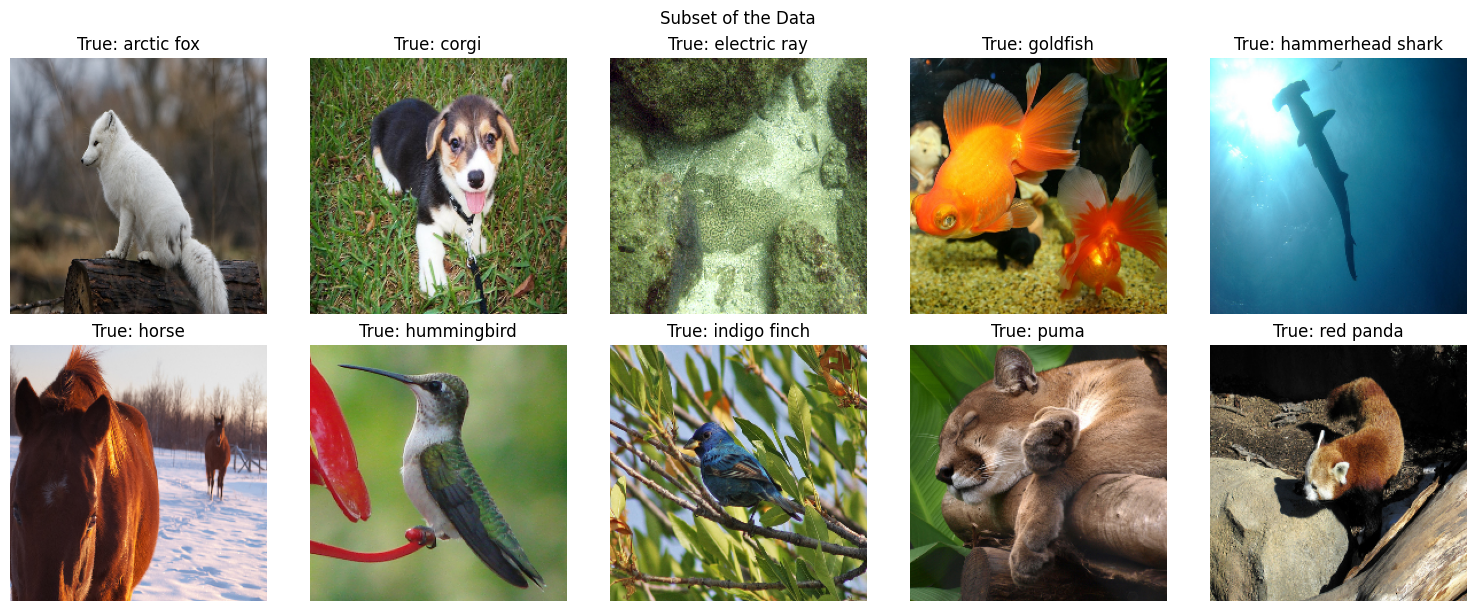

In [203]:
# view subset
fig, axs = plt.subplots(2, 5, figsize=(15, 6), constrained_layout=True)
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(images_subset[i])
    axs[i].axis("off")
    axs[i].set_title(f"True: {labels_list[true_labels[i]]}")
plt.suptitle("Subset of the Data")
plt.show()

### Adding Noise to the Data

In [204]:
# add gaussian noise to images
noisy_images1 = []
noisy_images2 = []
for image in images_subset:
    noise = np.random.normal(127, 50, image.shape)
    noisy_image1 = 0.5*image + 0.5*noise
    noisy_image1 = np.clip(noisy_image1, 0, 255)
    noisy_images1.append(noisy_image1)
    
    noisy_image2 = 0.7*image + 0.3*noise
    noisy_image2 = np.clip(noisy_image2, 0, 255)
    noisy_images2.append(noisy_image2)

In [205]:
# get predictions
predictions1 = get_predictions(noisy_images1)
predictions2 = get_predictions(noisy_images2)

In [ ]:
# show predictions on noisy images
fig, axs = plt.subplots(2, 5, figsize=(15, 6), constrained_layout=True)
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(noisy_images2[i].astype(np.uint8))
    axs[i].axis("off")
    axs[i].set_title(f"Predicted: {labels_list[predictions2[i]]}\nTrue: {labels_list[true_labels[i]]}")
plt.suptitle("Results on Less Noisy Images")
plt.show()

accuracy2 = (true_labels == torch.tensor(predictions2)).sum().item() / len(true_labels) * 100
print("Accuracy on less noisy images: {:.2f}%".format(accuracy2))

fig, axs = plt.subplots(2, 5, figsize=(15, 6), constrained_layout=True)
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(noisy_images1[i].astype(np.uint8))
    axs[i].axis("off")
    axs[i].set_title(f"Predicted: {labels_list[predictions1[i]]}\nTrue: {labels_list[true_labels[i]]}")
plt.suptitle("Results on Medium Noisy Images")
plt.show()

accuracy1 = (true_labels == torch.tensor(predictions1)).sum().item() / len(true_labels) * 100
print("Accuracy on medium noisy images: {:.2f}%".format(accuracy1))


Images still appear to be visually similar to the original images.

Slight addition of noise to the images does not affect the classification accuracy of the model. However, the classification accuracy decreases as the noise added to the image increases.

### Optimizing Image

In [231]:
def get_target_labels(model, images):
    target_labels1 = []
    target_labels2 = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for img in images:
            img = preprocess_image(img)
            img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
            output = model(img_tensor).to('cpu')
            _, sorted_indices = torch.sort(output, descending=True)
            target_labels1.append(sorted_indices[0, 1])
            target_labels2.append(sorted_indices[0, -1])
    return target_labels1, target_labels2

target_labels_1, target_labels_2 = get_target_labels(model_resnet18, images_subset)

In [232]:
# get the new images which appear similar to the original images
def optimize_image(model, image, target_label):
    model.to(device)
    # freeze model
    for param in model.parameters():
        param.requires_grad = False
    model.eval()
    
    image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
    image.requires_grad = True
    
    # optimize image for target_label1
    optimizer = optim.Adam([image], lr=0.01)
    for i in range(10):
        optimizer.zero_grad()
        output = model(image)
        loss = -output[0, target_label]
        loss.backward()
        optimizer.step()
        image.data.clamp(min_val_in_processed_img, max_val_in_processed_img)
        
    image = image.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    return image

In [233]:
modified_images_1 = []
modified_images_2 = []

for i, image in enumerate(images_subset):
    img = preprocess_image(image)
    modified_image1 = optimize_image(model_resnet18, img, target_labels_1[i])
    modified_image2 = optimize_image(model_resnet18, img, target_labels_2[i])
    modified_images_1.append(modified_image1)
    modified_images_2.append(modified_image2)

def get_predictions_from_mod_img(images):
    predictions = []
    model_resnet18.to(device)
    model_resnet18.eval()
    for img in images:
        img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
        output = model_resnet18(img_tensor).to('cpu')
        predictions.append(output.argmax(1)[0])
    return predictions

# perform predictions on modified images
predictions1 = get_predictions_from_mod_img(modified_images_1)
predictions2 = get_predictions_from_mod_img(modified_images_2)

In [ ]:
# show modified images
fig, axs = plt.subplots(10, 3, figsize=(6, 20), constrained_layout=True)
for i in range(10):
    axs[i, 0].imshow(images_subset[i])
    axs[i, 0].axis("off")
    axs[0, 0].set_title("Original")
    axs[i, 1].imshow(denormalize_image(modified_images_1[i]))
    axs[i, 1].axis("off")
    axs[0, 1].set_title("Modified to\nnext similar class")
    axs[i, 2].imshow(denormalize_image(modified_images_2[i]))
    axs[i, 2].axis("off")
    axs[0, 2].set_title("Modified to\nleast similar class")
plt.suptitle("Modified Images")
plt.show()

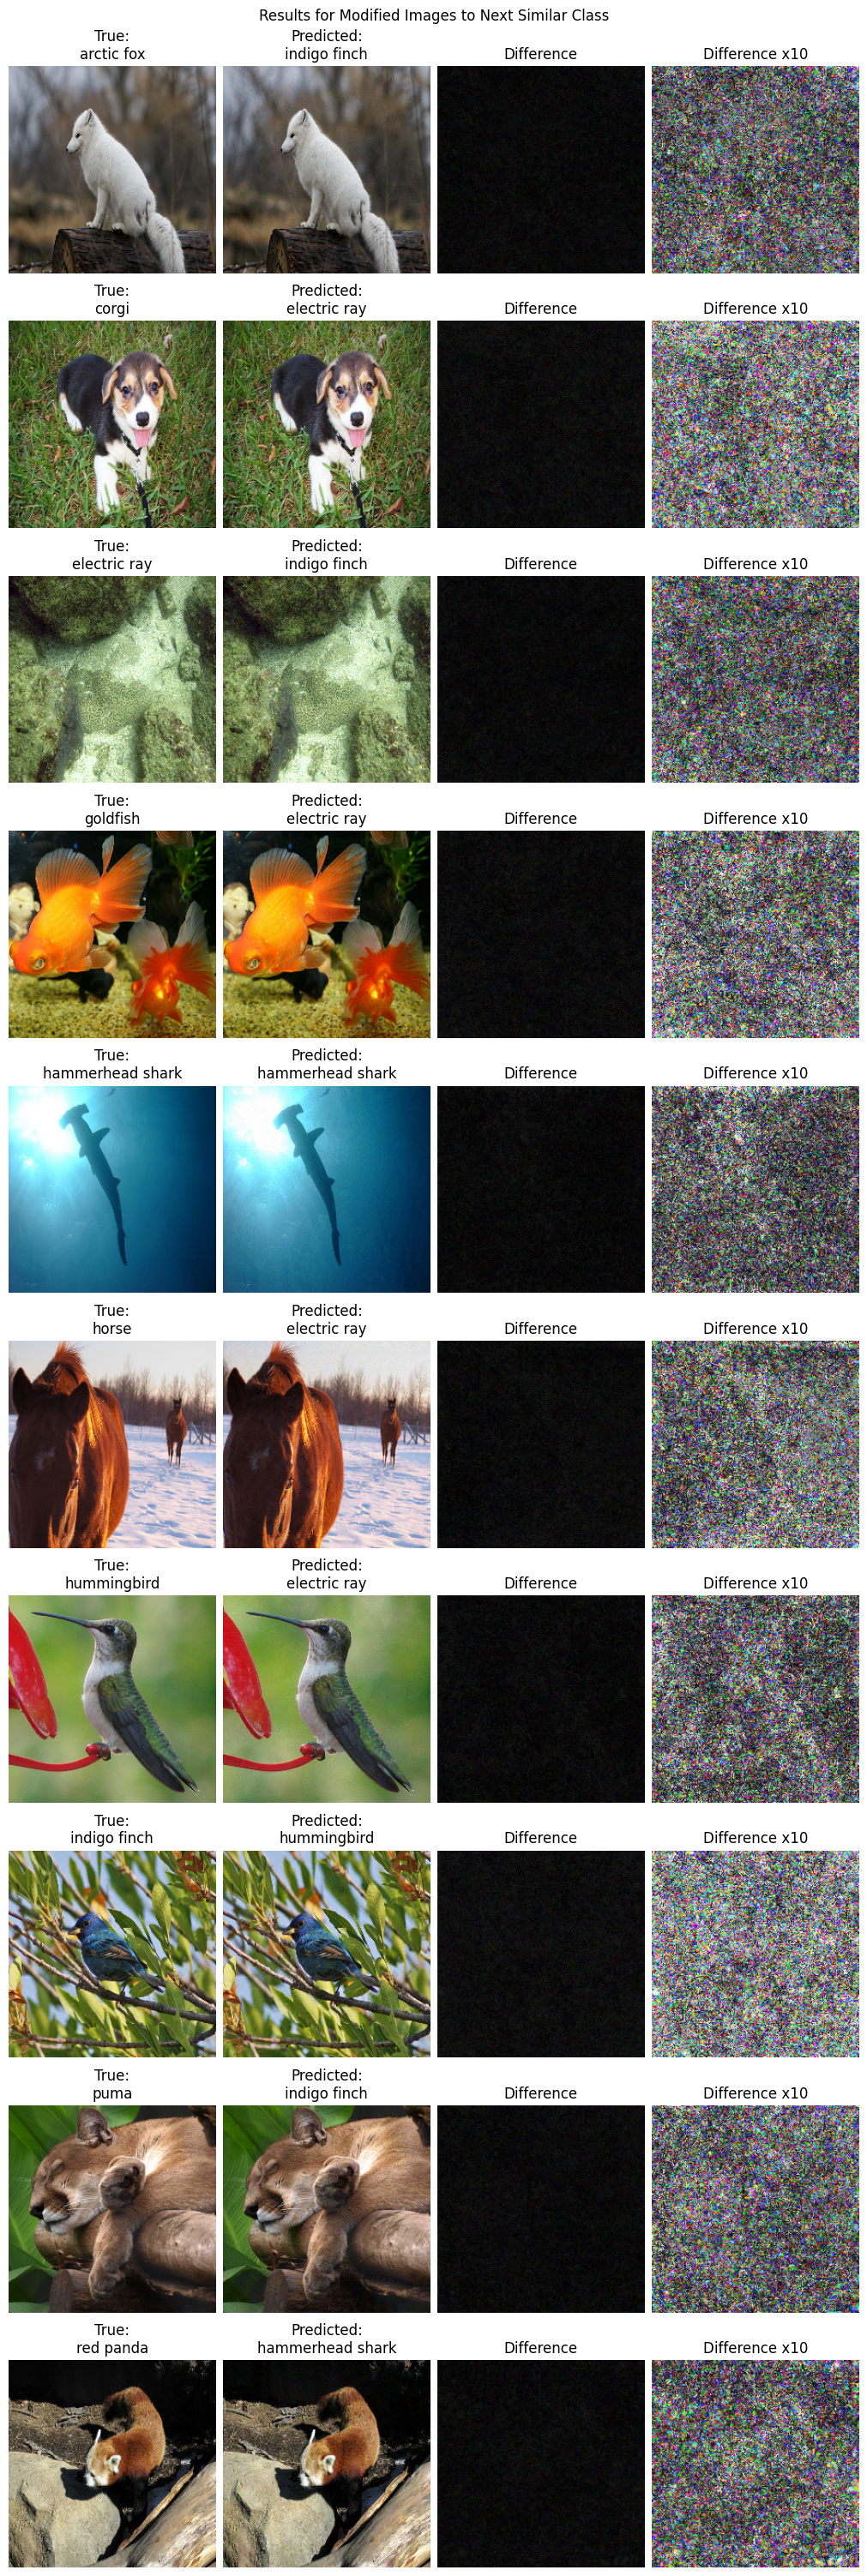

In [234]:
# show true, modified image, difference and magnified difference for each image
fig, axs = plt.subplots(10, 4, figsize=(10, 30), constrained_layout=True)
for i in range(10):
    axs[i, 0].imshow(images_subset[i])
    axs[i, 0].axis("off")
    axs[i, 0].set_title(f"True:\n{labels_list[true_labels[i]]}")
    axs[i, 1].imshow(denormalize_image(modified_images_1[i]))
    axs[i, 1].axis("off")
    axs[i, 1].set_title(f"Predicted:\n{labels_list[predictions1[i]]}")
    diff = np.abs(modified_images_1[i] - preprocess_image(images_subset[i]))
    diff = diff.clip(0, 0.1)
    axs[i, 2].imshow(diff, vmin=0, vmax=1)
    axs[i, 2].axis("off")
    axs[i, 2].set_title("Difference")
    axs[i, 3].imshow(diff*10, vmin=0, vmax=1)
    axs[i, 3].axis("off")
    axs[i, 3].set_title("Difference x10")
plt.suptitle("Results for Modified Images to Next Similar Class")
plt.show()